# Insert Catchy Name Here
In this notebook, we can begin to piece together our Python code that will match the environmental data up with the tagged species data.
Jackie has added useable parts of Trackpy and access to Ocean Color Data here (Aug4th 21:30 EDT)

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
from ftplib import FTP
import getpass
import os.path
from os import path
import netCDF4
from netCDF4 import Dataset
import folium
from folium.plugins import TimestampedGeoJson
from datetime import datetime

Read in tagged data and extract spatial domain

{'latitude': slice(24.44818354, 35.90428483, None),
 'longitude': slice(-82.06428163, -71.04951667, None)}

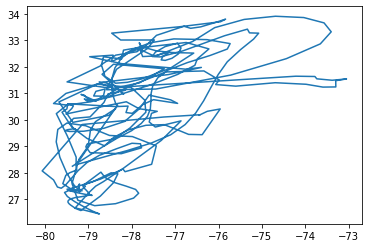

In [2]:
shark_dir = "track_shark144020.csv" # three years of track data from Laura's shark
track_ex = pd.read_csv(shark_dir, parse_dates=['datetime'])

## Keep longitude in degrees east
track_ex["lon"] = np.where(
    track_ex["lon"] > 180,
    track_ex["lon"] - 360,
    track_ex["lon"])

lat_min = track_ex["lat"].min() - 2.0
lat_max = track_ex["lat"].max() + 2.0
lon_min = track_ex["lon"].min() - 2.0
lon_max = track_ex["lon"].max() + 2.0

xy_bbox = dict(latitude=slice(lat_min,lat_max), longitude=slice(lon_min,lon_max))

plt.plot(track_ex.lon,track_ex.lat)

xy_bbox

Trackpy core: Python version of Xtractomatic tool often used in R and Matlab. Does not yes work for us, needs to be outfitted with appropriate environmental data. This piece of code seems to work through each row of the tagged data, and extract the environmental variable at the time and location of the tagged data.

In [3]:
sst_df_list = []
for index, row in track_ex.iterrows():
    row_time = pd.to_datetime(row["datetime"]) 
    x = row_time.strftime('%Y-%m-%d')
    row_lat_min = row["lat"] - 0.1
    row_lat_max = row["lat"] + 0.1
    row_lon_min = row["lon"] - 0.05
    row_lon_max = row["lon"] + 0.05
    row_bbox = subset_2014.sel(latitude=slice(row_lat_min,row_lat_max), longitude=slice(row_lon_min,row_lon_max))
    row_sst= row_bbox.sel(time=x)
    sst_xy_mean = row_sst.mean(dim=('latitude', 'longitude'))
    row_todf = sst_xy_mean.to_dataframe()
    #row_todf = row_sst.to_dataframe()
    sst_df_list.append(row_todf)
    #track_ex[]
    
sst_df = pd.concat(sst_df_list, ignore_index = True)
track_ex = pd.concat([track_ex, sst_df], axis=1)

NameError: name 'subset_2014' is not defined

could also grab a lot of the plotting code from the Trackpy code

Accessing ocean color data from MODIS-A and formatting in Xarray, slicing for tagged species data

In [4]:
# testing ocean color access with just a few tagged species datapoints
track_2014 = track_ex.iloc[0:10]

In [5]:
# calculate year day for time range of tagged data
day_list = []
year_list = []
for index, row in track_2014.iterrows():
    row_time = pd.to_datetime(row["datetime"])
    day_of_year = datetime(row_time.year, row_time.month, row_time.day).timetuple().tm_yday
    year_list.append(row_time.year)
    day_list.append(day_of_year)
day_string = [str(x) for x in day_list]
year_string = [str(x) for x in year_list]

# create access url for ocean color on opendap, merge datafiles to xarray
url = []
base_dir = 'https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/'
suffix = '.L3m_DAY_CHL_chlor_a_4km.nc'

k = 0
for day in day_string:
    url.append('https://oceandata.sci.gsfc.nasa.gov:443/opendap/MODISA/L3SMI/' + year_string[k] +'/' + day + '/A'+year_string[k] + day + '.L3m_DAY_CHL_chlor_a_4km.nc')
    k = k+1

def add_id(ds):
    ds.coords['time_coverage_start'] = ds.attrs['time_coverage_start']
    return ds

chl = xr.open_mfdataset(url, combine = 'nested', concat_dim='time_coverage_start', preprocess=add_id)
chl = chl.sel( lat=slice(lat_max, lat_min), lon=slice(lon_min,lon_max)) # these data have the lat indexed backwards... no idea why, but it works this way
chl

<xarray.Dataset>
Dimensions:              (lat: 275, lon: 265, time_coverage_start: 10, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat                  (lat) float32 35.9 35.85 35.81 ... 24.56 24.52 24.48
  * lon                  (lon) float32 -82.06 -82.02 -81.98 ... -71.1 -71.06
  * time_coverage_start  (time_coverage_start) <U24 '2014-11-15T00:00:01.000Z...
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    palette              (time_coverage_start, rgb, eightbitcolor) int8 dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
    chlor_a              (time_coverage_start, lat, lon) float32 dask.array<chunksize=(1, 275, 265), meta=np.ndarray>
Attributes: (12/65)
    _NCProperties:                     version=1|netcdflibversion=4.4.1.1|hdf...
    product_name:                      A2014319.L3m_DAY_CHL_chlor_a_4km.nc
    instrument:                        MODIS
    title:                             HMODISA Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          Aqua
    ...                                ...
    identifier_product_doi:            10.5067/AQUA/MODIS/L3M/CHL/2018
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         2116283
    data_minimum:                      0.008335022
    data_maximum:                      99.91856